In [166]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
import copy

import torch.nn as nn
import torch

from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm_notebook


import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri

robjects.numpy2ri.activate()
from rpy2.robjects.packages import importr

base = importr("base")
rvinecop = importr("rvinecopulib")
eecop = importr("eecop")
stats = importr("stats")

lower_tau = 0.025
upper_tau = 0.975

from sklearn.datasets import make_moons


def moons(n):
    x, y = make_moons(1000, noise=0.1)
    return torch.Tensor(x), torch.Tensor(y).view(-1, 1)


def simple_network(n_inputs=1, n_outputs=1, n_hiddens=100):
    return torch.nn.Sequential(
        torch.nn.Linear(n_inputs, n_hiddens),
        torch.nn.ReLU(),
        torch.nn.Linear(n_hiddens, n_hiddens),
        torch.nn.ReLU(),
        torch.nn.Linear(n_hiddens, n_hiddens),
        torch.nn.ReLU(),
        torch.nn.Linear(n_hiddens, 1),
    )

def generate_data(n=1024):
    f_c = 5
    A_m = 1
    A_c = 1
    f_m = 1
    modulation_index = 1

    x1 = torch.linspace(0, 0.3, n // 3).view(-1, 1)
    x2 = torch.linspace(0.7, 1, n // 3).view(-1, 1)
    x3 = torch.linspace(0.4, 0.5, n // 100).view(-1, 1)
    x = torch.cat((x1, x3, x2))

    carrier = (2 * np.pi * f_c * x).cos() * A_c
    modulator = (2 * np.pi * f_m * x).cos() * A_m
    signal = (
        A_c
        * (1 + modulation_index * (2 * np.pi * f_m * x).cos())
        * (2 * np.pi * f_c * x).cos()
    )
    # noise = torch.zeros(x.shape[0], 1).normal_(0, 0.3)
    noise = (3 * x) * torch.zeros(x.shape[0], 1).normal_(0, 0.3)
    y = signal + noise
    x_test = torch.linspace(-0.25, 1.25, 100).view(-1, 1)

    return x, y, x_test


def train_network(x, y, epochs=2000):
    net = simple_network(x.size(1), y.size(1))
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters())
    loader = DataLoader(TensorDataset(x, y), shuffle=True, batch_size=128)

    for _ in tqdm_notebook(range(epochs)):
        for xi, yi in loader:
            optimizer.zero_grad()
            loss(net(xi), yi).backward()
            optimizer.step()

    return net


def boot_feat_target(net, x, y, test_x, vine_f_y, epochs=500, loss="MSE"):

    np.random.seed()

    f_dim = net[:-2][-1]._parameters["weight"].shape[0]
    bootstrap_data_new = np.asarray(rvinecop.rvine(x.shape[0], vine_f_y))

    np.random.seed(1)
    torch.manual_seed(1)
    net_boot = copy.deepcopy(net[-2:])
    if loss == "MSE":
        loss = torch.nn.MSELoss()
    else:
        loss = torch.nn.BCEWithLogitsLoss()

    optimizer_boot = torch.optim.Adam(net_boot.parameters())
    loader = DataLoader(
        TensorDataset(
            torch.Tensor(bootstrap_data_new[:, :f_dim]),
            torch.Tensor(bootstrap_data_new[:, f_dim]).view(-1, 1),
        ),
        shuffle=True,
        batch_size=bootstrap_data_new[:, :f_dim].shape[0],
    )  # batch training

    for _ in range(epochs):
        for xi, yi in loader:
            optimizer_boot.zero_grad()
            loss(net_boot(xi), yi).backward()
            optimizer_boot.step()

    pred_boot = net_boot(net[:-2](test_x)).detach().numpy().ravel()

    return pred_boot


# train main network ########################################################

torch.manual_seed(1)

x, y, test_x = generate_data2(2000)

x_tr, x_val, y_tr, y_val = train_test_split(x, y, test_size=0.5, random_state=42)


test_x = (test_x - x_tr.mean(0)) / x_tr.std(0)
x_val = (x_val - x_tr.mean(0)) / x_tr.std(0)
x_tr = (x_tr - x_tr.mean(0)) / x_tr.std(0)

net = train_network(x_tr, y_tr)

pred_med = net(test_x).detach().numpy().ravel()


The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


/usr/local/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


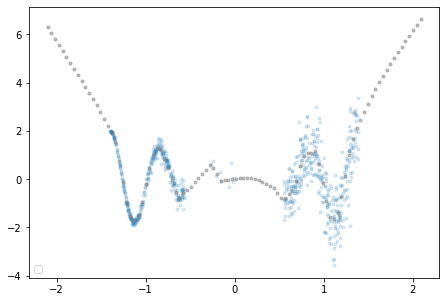

<IPython.core.display.Javascript object>

In [167]:
plt.plot(x_tr.numpy(), y_tr.numpy(), ".", alpha=0.15)

plt.plot(test_x.view(-1).numpy(), pred_med, ".", color="gray", alpha=0.5, lw=2)
plt.legend(loc=3)
plt.tight_layout(0, 0, 0)
plt.show()

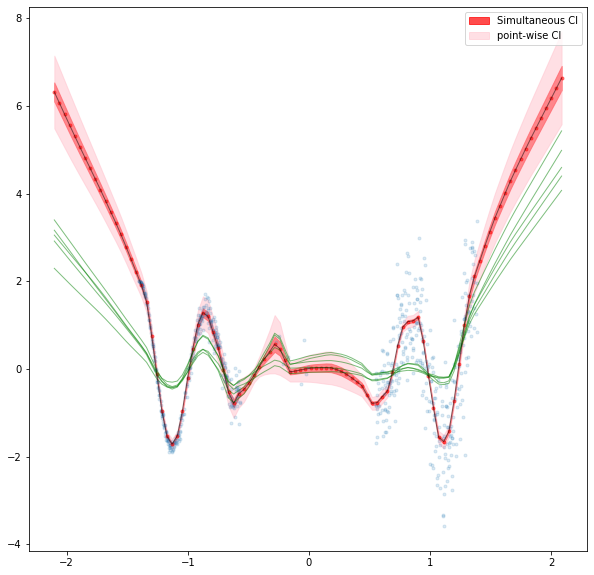

<IPython.core.display.Javascript object>

In [192]:
# fit a vine copula on validation set, set aside from the train
f_val = net[:-2](x_val).detach()
bootstrap_data_val = torch.cat((f_val, y_val.view(-1, 1)), dim=1).numpy()
copula_controls = base.list(mult=1, trunc_lvl=3, family_set="tll")
vine_obj_new = rvinecop.vine(bootstrap_data_val, copula_controls=copula_controls)

pred_med = net(test_x).detach().numpy().ravel()
plt.figure(figsize=(10, 10))
plt.plot(x_tr.numpy(), y_tr.numpy(), ".", alpha=0.15)
plt.plot(test_x.view(-1).numpy(), pred_med, ".", color="red", alpha=0.5, lw=1)

bootstraped_low = []
bootstraped_upper = []
bootstraped_median = []
bootstraped_preds = []

for boot_p in range(5):
    new_pred = np.asarray(
        boot_feat_target(net, x_val, y_val, test_x, vine_obj_new, epochs=500)
    ).flatten()
    plt.plot(test_x.numpy(), new_pred, color="green", alpha=0.5, lw=1)

    bootstraped_preds.append(torch.Tensor(new_pred - pred_med))

bootstraped_preds = torch.squeeze(torch.stack(bootstraped_preds, 1))

# standard error is sample std dev divided by sqrt(sample size))
se = bootstraped_preds.std(1).div(np.sqrt(bootstraped_preds.shape[0]))
masd = np.apply_along_axis(np.max, 0, se.abs())  # apply(absDev, 2L, max)
crit = np.quantile(masd, 0.95)

pred_med = net(test_x).detach()
uprS = (pred_med.view(-1) + (crit * se),)
lwrS = (pred_med.view(-1) - (crit * se),)

uprP = (pred_med.view(-1) + (2 * se),)
lwrP = (pred_med.view(-1) - (2 * se),)


uper_q = np.apply_along_axis(np.quantile, 1, bootstraped_preds, 0.975)
lower_q = np.apply_along_axis(np.quantile, 1, bootstraped_preds, 0.025)


plt.plot(test_x.view(-1).numpy(), pred_med, color="black", alpha=0.5, lw=1)
plt.fill_between(
    test_x.view(-1).numpy(),
    uprS[0].view(-1).numpy(),
    lwrS[0].view(-1).numpy(),
    color="red",
    alpha=0.7,
    label="Simultaneous CI",
)
plt.fill_between(
    test_x.view(-1).numpy(),
    uprP[0].view(-1).numpy(),
    lwrP[0].view(-1).numpy(),
    color="pink",
    alpha=0.5,
    label="point-wise CI",
)

plt.legend()

# Prediction intervals

In [173]:
f_val = net[:-2](x_val).detach()
res_eecop = eecop.eecop(y_val.view(-1, 1).numpy(),
                            f_val.numpy(),
                            copula_method = "vine",
                            margin_method = "kde",
                            mult=0.01, 
                            trunc_lvl=1)
f_test = net[:-2](test_x).detach()
pred_low_b = []
pred_hig_b = []
step_size = 20
for i in range(0, f_test.shape[0], step_size):
    pl = stats.predict(res_eecop, f_test.numpy()[i:i+step_size,:], type="quantile", t=lower_tau)
    ph = stats.predict(res_eecop, f_test.numpy()[i:i+step_size,:], type="quantile", t=upper_tau)
    pred_low_b.append(list(pl))
    pred_hig_b.append(list(ph))



<IPython.core.display.Javascript object>

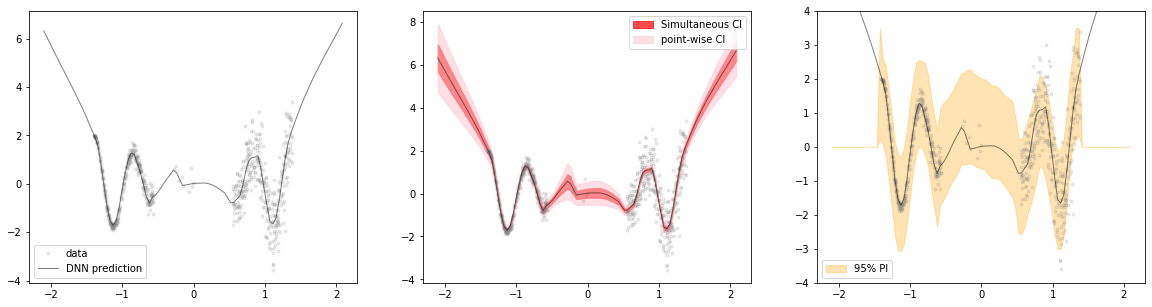

<IPython.core.display.Javascript object>

In [175]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(x_tr.numpy(), y_tr.numpy(), ".", alpha=0.15, label="data", color="gray")

ax1.plot(
    test_x.view(-1).numpy(),
    pred_med,
    color="black",
    alpha=0.5,
    lw=1,
    label="DNN prediction",
)
ax1.legend()


ax2.plot(x_tr.numpy(), y_tr.numpy(), ".", alpha=0.15, color="gray")

ax2.plot(test_x.view(-1).numpy(), pred_med, color="black", alpha=0.5, lw=1)
ax2.fill_between(
    test_x.view(-1).numpy(),
    uprS[0].view(-1).numpy(),
    lwrS[0].view(-1).numpy(),
    color="red",
    alpha=0.7,
    label="Simultaneous CI",
)
ax2.fill_between(
    test_x.view(-1).numpy(),
    uprP[0].view(-1).numpy(),
    lwrP[0].view(-1).numpy(),
    color="pink",
    alpha=0.5,
    label="point-wise CI",
)

ax2.legend()
ax3.plot(x_tr.numpy(), y_tr.numpy(), ".", alpha=0.15, color="gray")
ax3.plot(test_x.view(-1).numpy(), pred_med, color="black", alpha=0.5, lw=1)
ax3.fill_between(
    test_x.view(-1).numpy(),
    np.nan_to_num(np.asarray(pred_low_b).ravel()),
    np.nan_to_num(np.asarray(pred_hig_b).ravel()),
    alpha=0.3,
    color="orange",
    label="95% PI",
)
plt.ylim(-4, 4)

ax3.legend()

# Classsification task - moons dataset

In [182]:
torch.manual_seed(0)
n = 1000
margin = 0.25

x_moons, y_moons = moons(n)

lim = 11

x1, x2 = torch.meshgrid(torch.linspace(-lim, lim, 25),
                            torch.linspace(-lim, lim, 25))

x_test_moons = torch.cat((x1.reshape(-1, 1),
                        x2.reshape(-1, 1)), -1)
x_tr_m, x_val_m, y_tr_m, y_val_m = train_test_split(x_moons, y_moons, test_size=0.5, random_state=42)


loss = torch.nn.BCEWithLogitsLoss()

net_moons = torch.nn.Sequential(
            torch.nn.Linear(x_moons.size(1), 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 1))

opt_moons = torch.optim.Adam(net_moons.parameters(), weight_decay=1e-3)
loader_moons = DataLoader(TensorDataset(x_tr_m, y_tr_m), shuffle=True, batch_size=128)
epochs = 500
for _ in tqdm_notebook(range(epochs)):
    for xi, yi in loader_moons:
            opt_moons.zero_grad()
            loss(net_moons(xi), yi).backward()
            opt_moons.step()

preds = net_moons(x_test_moons).view(25, 25).detach()

f_moons = net_moons[:-2](x_val_m).detach()
bootstrap_data_moons = torch.cat((f_moons, y_val_m.view(-1, 1)), dim=1).numpy()
copula_controls = base.list(mult=1, trunc_lvl=3, family_set = "tll")
vine_obj_moons = rvinecop.vine(bootstrap_data_moons, copula_controls = copula_controls)
print('Vine copula fitted')

bootstraped_preds_moons2 = []
for boot_p in range(15):
    new_pred = np.asarray(boot_feat_target(net_moons, x_val_m, y_val_m, x_test_moons, vine_obj_moons, epochs=500, loss="BCE")).flatten()
    bootstraped_preds_moons2.append(torch.Tensor(new_pred - preds.numpy().flatten()))

bootstraped_preds_moons_st2 = torch.squeeze(torch.stack(bootstraped_preds_moons2, 1))

res_eecop_moons = eecop.eecop(net_moons(x_val_m).detach().view(-1, 1).numpy(),
                            f_moons.numpy(),
                            copula_method = "vine",
                            margin_method = "kde",
                            mult=1, 
                            trunc_lvl=3)
f_test_moons = net_moons[:-2](x_test_moons).detach()

pred_low_b_moons = []
pred_hig_b_moons = []
step_size = 25
for i in range(0, f_test_moons.shape[0], step_size):
    pl = stats.predict(res_eecop_moons, f_test_moons.numpy()[i:i+step_size,:], type="quantile", t=lower_tau)
    ph = stats.predict(res_eecop_moons, f_test_moons.numpy()[i:i+step_size,:], type="quantile", t=upper_tau)
    pred_low_b_moons.append(list(pl))
    pred_hig_b_moons.append(list(ph))


uncertainties_ale = torch.Tensor(np.nan_to_num(np.asarray(pred_hig_b_moons)).ravel() - np.nan_to_num(np.asarray(pred_low_b_moons)).ravel())



/usr/local/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Vine copula fitted


<IPython.core.display.Javascript object>

In [187]:
uncertainties_epi = bootstraped_preds_moons_st2.view(25, 25, -1).numpy().std(axis=-1)

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


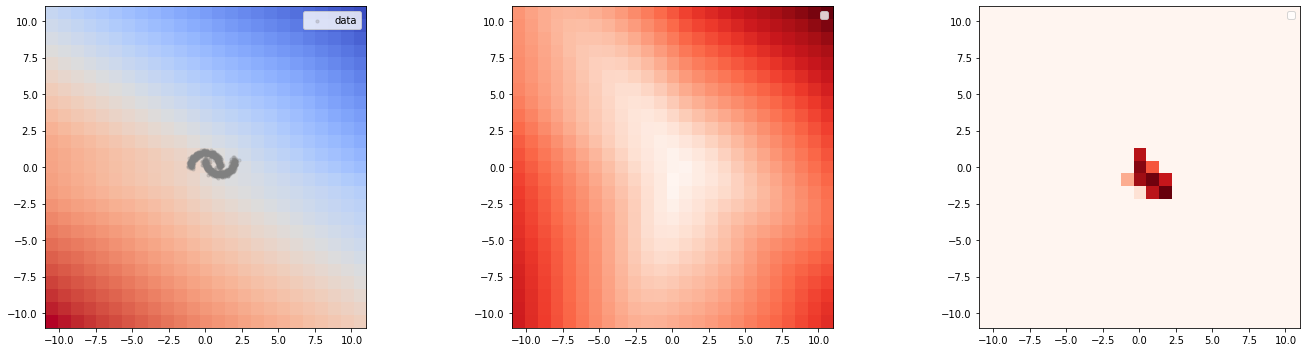

<IPython.core.display.Javascript object>

In [188]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.scatter(x_moons[:, 0], x_moons[:, 1], color="gray", alpha=0.25, s=10, label="data")

ax1.imshow(
    preds,
    cmap="coolwarm",
    origin="upper",
    extent=(-lim, lim, -lim, lim),
    label="DNN prediction",
)
ax1.legend()
ax2.imshow(
    uncertainties_epi, cmap="Reds", extent=(-lim, lim, -lim, lim), label="Epistemic"
)
ax2.legend()

ax3.imshow(
    uncertainties_ale.reshape(25, 25),
    cmap="Reds",
    extent=(-lim, lim, -lim, lim),
    label="Aleatoric",
)
ax3.legend()
plt.legend()
plt.tight_layout()
plt.show()

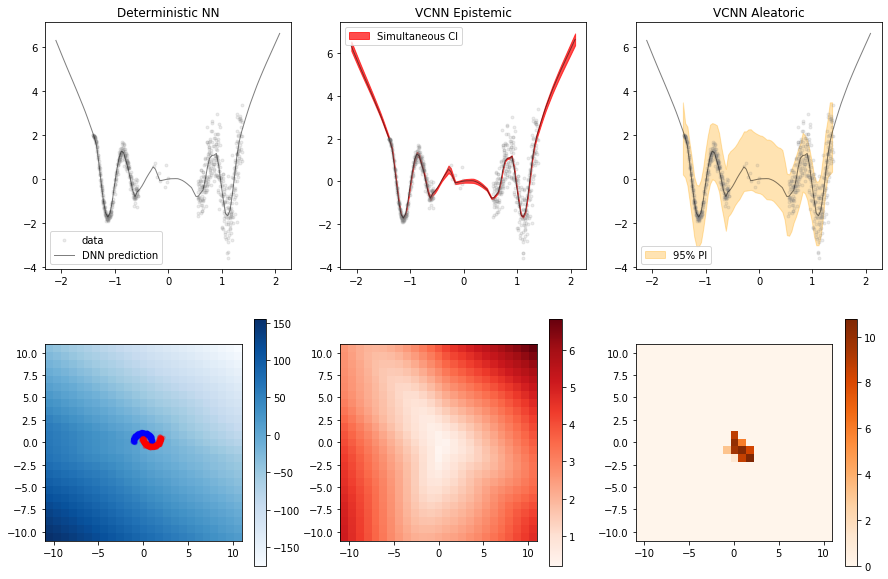

<IPython.core.display.Javascript object>

In [193]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

ax1.plot(x_tr.numpy(), y_tr.numpy(), ".", alpha=0.15, label="data", color="gray")

ax1.plot(
    test_x.view(-1).numpy(),
    pred_med,
    color="black",
    alpha=0.5,
    lw=1,
    label="DNN prediction",
)
ax1.legend()
ax1.set_title("Deterministic NN")

ax2.plot(x_tr.numpy(), y_tr.numpy(), ".", alpha=0.15, color="gray")

ax2.plot(test_x.view(-1).numpy(), pred_med, color="black", alpha=0.5, lw=1)

ax2.fill_between(
    test_x.view(-1).numpy(),
    uprS[0].view(-1).numpy(),
    lwrS[0].view(-1).numpy(),
    color="red",
    alpha=0.7,
    label="Simultaneous CI",
)
ax2.legend()
ax2.set_title("VCNN Epistemic")


ax3.plot(x_tr.numpy(), y_tr.numpy(), ".", alpha=0.15, color="gray")
ax3.plot(test_x.view(-1).numpy(), pred_med, color="black", alpha=0.5, lw=1)

ax3.fill_between(
    test_x.view(-1).numpy(),
    np.asarray(pred_hig_b).flatten(),
    np.asarray(pred_low_b).flatten(),
    alpha=0.3,
    color="orange",
    label="95% PI",
)
ax3.legend()
ax3.set_title("VCNN Aleatoric")

import matplotlib

preds_l = net_moons(x_moons).detach().numpy().ravel()
bs = net_moons(x_moons).detach().numpy().ravel()
preds_l[bs < 0] = 1
preds_l[bs > 0] = 0

colors = ["red", "blue"]
ax4.scatter(
    x_moons[:, 0],
    x_moons[:, 1],
    c=preds_l,
    cmap=matplotlib.colors.ListedColormap(colors),
    alpha=0.25,
    s=10,
    label="data",
)

im1 = ax4.imshow(
    net_moons(x_test_moons).detach().numpy().reshape(25, 25),
    cmap="Blues",
    origin="upper",
    extent=(-lim, lim, -lim, lim),
    label="DNN prediction",
)
fig.colorbar(im1, ax=ax4)

im2 = ax5.imshow(
    uncertainties_epi, cmap="Reds", extent=(-lim, lim, -lim, lim), label="Epistemic"
)
fig.colorbar(im2, ax=ax5)

im3 = ax6.imshow(
    uncertainties_ale.reshape(25, 25),
    cmap="Oranges",
    extent=(-lim, lim, -lim, lim),
    label="Aleatoric",
)

fig.colorbar(im3, ax=ax6)
plt.savefig("motivating_example_best.pdf")